In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNetCV

from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


from utils_data_structures import col_prefixes

In [23]:
grouped_df = pd.read_csv('sorare_data/large_grouped_sorare_data.csv')

grouped_df = grouped_df.fillna(0.0)

print(grouped_df['So_5_Scores_9'].isna().sum())

0


In [24]:
# get dummies for current club
# processed_df = pd.get_dummies(grouped_df, columns=['Current_Club'])
processed_df = grouped_df.drop(columns=['Current_Club'])
le = LabelEncoder()
processed_df['Position_Encoded'] = le.fit_transform(processed_df['Position'])

columns_to_drop = ['Display_Name', 'First_Name','Last_Name','Player_Number', 'Position']
processed_df = processed_df.drop(columns=columns_to_drop)

processed_df.fillna(0.0)

# pd.set_option('display.max_columns', None)
processed_df.dtypes.value_counts()

float64    308
int64        4
int32        1
Name: count, dtype: int64

In [25]:
# Create X and y and split into training and testing sets
target_column = 'So_5_Scores_9'
columns_to_drop = [f'{col}_9' for col in col_prefixes]

X = processed_df.drop(columns=columns_to_drop)
y = processed_df[target_column]

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Best model used 2 folds with MSE: 257.9460061138345 | rmse: 16.060697560001387
# Best alpha: 0.05
# Best l1_ratio: 0.9

# Initialize
elastic_model = ElasticNet(alpha=0.05, l1_ratio=0.9, random_state=42)

# Train the model
elastic_model.fit(X_train, y_train)

# Make predictions
y_pred = elastic_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'r2: {r2}')

KeyboardInterrupt: 

In [20]:


# Define the ElasticNet model
elastic_net = ElasticNet()

# Create a pipeline with scaling and ElasticNet
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Feature scaling
    ('elastic_net', elastic_net)
])

# Best parameters found: {'elastic_net__alpha': 0.1, 'elastic_net__l1_ratio': 1.0}
alpha_values = [1e-6, 1e-5, 1e-4, 1e-3, 0.01, 0.1, 1, 10, 100, 1000, 10000]
l1_ratio_values = [0.01, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8, 0.9, 0.95, 1.0]

alpha_values = np.arange(0.05, 1, 0.05)
# alpha_values = np.arange(0.001, 0.5, 0.05)
alphas = alpha_values.tolist()

l1_ratio_numbers = np.arange(0.1, 1, 0.1)
l1_ratios = l1_ratio_numbers.tolist()

# Define the hyperparameter grid
param_grid = {
    'elastic_net__alpha': alpha_values,  # Regularization strength
    'elastic_net__l1_ratio': l1_ratio_values       # L1 ratio (Lasso/Ridge balance)
}

# Setup GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit GridSearchCV to find the best hyperparameters
grid_search.fit(X_train, y_train)

# Print the best hyperparameters
print("Best parameters found:", grid_search.best_params_)

# Predict using the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'RMSE: {rmse}')

r2 = r2_score(y_test, y_pred)
print(f'r2: {r2}')

Best parameters found: {'elastic_net__alpha': 0.25, 'elastic_net__l1_ratio': 1.0}
RMSE: 16.477791542304995
r2: 0.5313271129915589


In [16]:

best_model = None
best_cv = None
best_mse = 100000
best_rmse = 100000
best_r2 = 5

alpha_numbers = np.arange(0.05, 1, 0.05)
alpha_numbers = np.arange(0.001, 0.5, 0.05)
alphas = alpha_numbers.tolist()

l1_ratio_numbers = np.arange(0.1, 1, 0.1)
l1_ratios = l1_ratio_numbers.tolist()

for cv in range(2, 6):
    print(f"Testing ElasticNetCV with {cv} folds...")
    model_cv = ElasticNetCV(
        alphas=alphas,        # Range of alpha values to test
        l1_ratio=l1_ratios,       # Range of l1_ratio values to test
        cv=cv,                           # Number of cross-validation folds
        random_state=42,
        n_jobs=-1,
    )

    # Fit the model
    model_cv.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model_cv.predict(X_test)
    
    # Calculate mean squared error
    y_pred_clipped = np.clip(y_pred, 0, 100)
    mse = mean_squared_error(y_test, y_pred_clipped)
    rmse = np.sqrt(mse)
    print(f"Root Mean Squared Error for cv={cv}: {rmse}")
    r2 = r2_score(y_test, y_pred)
    print(f'r2: {r2}')
    
    # Save the best model based on MSE
    if r2 < best_r2:
        best_mse = mse
        best_rmse = rmse
        best_cv = cv
        best_model = model_cv
        best_r2 = r2

# Output the best model and its performance
print(f"\nBest model used {best_cv} folds with MSE: {best_mse} | rmse: {best_rmse} | r2: {best_r2}")
print(f"Best alpha: {best_model.alpha_}")
print(f"Best l1_ratio: {best_model.l1_ratio_}")

# Best alpha: 0.451
# Best l1_ratio: 0.9

Testing ElasticNetCV with 2 folds...


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 189217.61954884615, tolerance: 376.17247408882616
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 91434.70911787916, tolerance: 383.58484970745934
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 616316.0870488284, tolerance: 376.172474

Root Mean Squared Error for cv=2: 16.466944284266397
r2: 0.5316478394925117
Testing ElasticNetCV with 3 folds...


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 294565.860413593, tolerance: 510.13878129576216
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 351665.06043999596, tolerance: 502.9608298531935
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44953.17283960292, tolerance: 502.96082985

Root Mean Squared Error for cv=3: 16.377211325585147
r2: 0.53661800155552
Testing ElasticNetCV with 4 folds...


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2582.152763020713, tolerance: 573.9322035869211
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 78681.74728882243, tolerance: 566.823375483861
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 499340.3600451598, tolerance: 569.1189497055

Root Mean Squared Error for cv=4: 16.38519379906074
r2: 0.5361486730971364
Testing ElasticNetCV with 5 folds...


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 12627.011446604505, tolerance: 606.3485070890819
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 874195.4544102068, tolerance: 609.28262870588
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 60382.5265810485, tolerance: 606.34850708908

Root Mean Squared Error for cv=5: 16.379017690131313
r2: 0.5364961508485565

Best model used 2 folds with MSE: 271.16025406113374 | rmse: 16.466944284266397 | r2: 0.5316478394925117
Best alpha: 0.451
Best l1_ratio: 0.9


c:\Users\mttca\nwuai\course_materials\class_work\projects\Project_2\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.669e+06, tolerance: 7.598e+02
  model = cd_fast.enet_coordinate_descent(


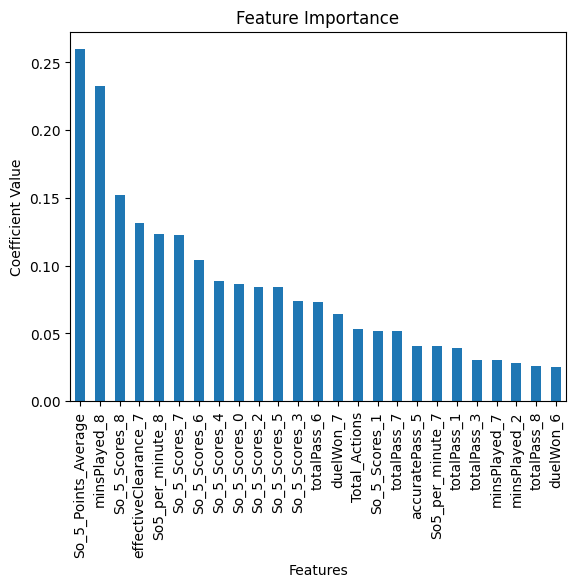

In [17]:
feature_importance = pd.Series(best_model.coef_, index=X_train.columns)
feature_importance = feature_importance.abs().sort_values(ascending=False).head(25)
feature_importance.sort_values(ascending=False).plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.show()